In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import cv2
import pathlib
from tqdm import tqdm
import copy
from collections import OrderedDict
from typing import Tuple
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Preparing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CMPT983/animals_dataset_0309.zip

In [ ]:
train_data_dir = '/content/animals_dataset_0309/training'
train_data_dir = pathlib.Path(train_data_dir)

test_data_dir = '/content/animals_dataset_0309/testing'
test_data_dir = pathlib.Path(test_data_dir)

In [ ]:
img_height,img_width=256,256
batch_size=32

data_augmentation = ImageDataGenerator(
    rotation_range=10,       # Random rotations
    width_shift_range=0.1,   # Random horizontal shifts
    height_shift_range=0.1,  # Random vertical shifts
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flips
    fill_mode='nearest'      # Fill strategy
)

train_ds = data_augmentation.flow_from_directory(
    train_data_dir,                  # Make sure this points to your training data directory
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 654 images belonging to 4 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 165 files belonging to 4 classes.


# Constructing the Model

In [ ]:
@keras.saving.register_keras_serializable(package="my_model")
class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height, img_width, 3),
                   pooling='avg',classes=4,
                   weights='imagenet')
        for layer in self.pretrained_model.layers:
                layer.trainable=False
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(512, activation="relu")
        self.dense2 = keras.layers.Dense(4, activation="softmax")
        # self.cnt = tf.Variable(0, trainable=False)
        # self.cnt_loss = tf.Variable(0, trainable=False)
        self.alpha = tf.Variable(0, trainable=False)
        self.shuffled_indices = tf.Variable([], trainable=False)
        self.flag = tf.Variable(0, trainable=False)
        # self.log_data = []

    def call(self, inputs, training=None):
        self.flag = 0
        x = self.pretrained_model(inputs)
        x = self.flatten(x)

        # manifold mixup
        if training:
          self.flag = 1
          # self.cnt.assign_add(1)
          self.alpha = tf.random.uniform(shape=[], minval=0.85, maxval=1)
          x_a = x
          indices = tf.range(tf.shape(x_a)[0])
          shuffled_indices = tf.random.shuffle(indices)
          self.shuffled_indices = shuffled_indices
          x_b = tf.gather(x_a, shuffled_indices)
          x = self.alpha * x_a + (1 - self.alpha) * x_b

          # Writing alpha and shuffled_indices to a text file
          # log_str = tf.strings.format("Alpha: {}, Shuffled Indices: {}\n", (self.alpha, shuffled_indices))
          # self.log_data.append(log_str.numpy().decode('utf-8'))
        # end of manifold mixup

        x = self.dense1(x)
        x = self.dense2(x)

        return x

    # def write_logs(self, filename="mixup_log.txt"):
    #     with open(filename, "w") as file:
    #         for log in self.log_data:
    #             file.write(log)
    #     self.log_data.clear()

resnet_model_1 = MyModel()
resnet_model_1.build((None, img_height, img_width, 3))

In [ ]:
resnet_model_1.summary()

Model: "my_model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_50 (Flatten)        multiple                  0         
                                                                 
 dense_100 (Dense)           multiple                  1049088   
                                                                 
 dense_101 (Dense)           multiple                  2052      
                                                                 
Total params: 24638853 (93.99 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 23587713 (89.98 MB)
_________________________________________________________________


# Loss Function

In [ ]:
@keras.saving.register_keras_serializable(package="my_loss", name="mixup_criterion")
def mixup_criterion(y_a, pred, criterion=tf.losses.CategoricalCrossentropy(),):
    # print(resnet_model_1.flag)
    # print(y_a)
    # print(pred)
    """ Updated loss for mixup.
    Args:
    -----
    criterion: loss function to use, example: crossentropy loss
    preds: predictions from network
    y_a: original labels
    y_b: labels of the shuffled batch
    lam: alpha used for mixup
    """
    # if resnet_model_1.flag%2 == 0:
    #     resnet_model_1.cnt_train.assign_add(1)
    # else:
    #     resnet_model_1.cnt_val.assign_add(1)

    # if resnet_model_1.cnt_train == len(train_ds) or resnet_model_1.cnt_val == len(val_ds):
    #     resnet_model_1.flag.assign_add(1)
    #     resnet_model_1.cnt_train.assign(0)
    #     resnet_model_1.cnt_val.assign(0)

    # resnet_model_1.cnt.assign_add(1)

    if resnet_model_1.flag == 1:
        # resnet_model_1.cnt_loss.assign_add(1)
        # tf.print(resnet_model_1.shuffled_indices)
        y_b = tf.gather(y_a, resnet_model_1.shuffled_indices)
        return resnet_model_1.alpha * criterion(y_a, pred) + (1 - resnet_model_1.alpha) * criterion(y_b, pred)
    else:
        return criterion(y_a, pred)


# Training the Model (without mixup)

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
history = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

Epoch 1/30
21/21 [==============================] - 13s 470ms/step - loss: 1.3626 - accuracy: 0.6927 - val_loss: 0.5724 - val_accuracy: 0.7818
Epoch 2/30
21/21 [==============================] - 9s 436ms/step - loss: 0.4571 - accuracy: 0.8318 - val_loss: 0.4863 - val_accuracy: 0.8000
Epoch 3/30
21/21 [==============================] - 9s 436ms/step - loss: 0.3514 - accuracy: 0.8486 - val_loss: 0.4201 - val_accuracy: 0.8364
Epoch 4/30
21/21 [==============================] - 9s 435ms/step - loss: 0.2837 - accuracy: 0.8869 - val_loss: 0.3885 - val_accuracy: 0.8424
Epoch 5/30
21/21 [==============================] - 9s 450ms/step - loss: 0.2129 - accuracy: 0.9083 - val_loss: 0.4343 - val_accuracy: 0.8182
Epoch 6/30
21/21 [==============================] - 9s 438ms/step - loss: 0.1840 - accuracy: 0.9235 - val_loss: 0.3975 - val_accuracy: 0.8727
Epoch 7/30
21/21 [==============================] - 9s 433ms/step - loss: 0.1599 - accuracy: 0.9450 - val_loss: 0.3871 - val_accuracy: 0.8727
Epoch

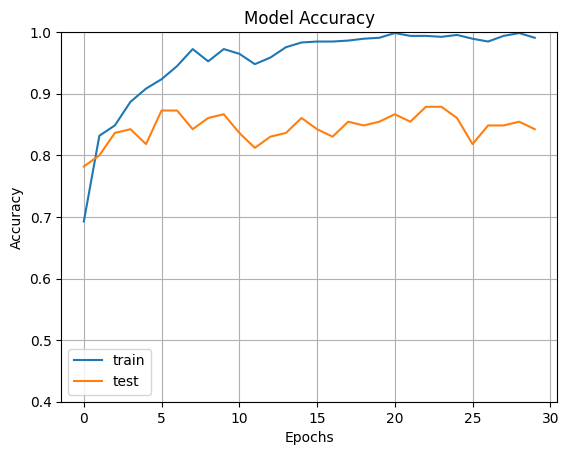

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
history_1 = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

Epoch 1/30
21/21 [==============================] - 15s 476ms/step - loss: 1.0740 - accuracy: 0.7187 - val_loss: 0.5842 - val_accuracy: 0.8061
Epoch 2/30
21/21 [==============================] - 9s 436ms/step - loss: 0.3884 - accuracy: 0.8471 - val_loss: 0.4704 - val_accuracy: 0.8485
Epoch 3/30
21/21 [==============================] - 9s 437ms/step - loss: 0.3305 - accuracy: 0.8746 - val_loss: 0.3946 - val_accuracy: 0.8364
Epoch 4/30
21/21 [==============================] - 9s 436ms/step - loss: 0.2234 - accuracy: 0.9113 - val_loss: 0.4305 - val_accuracy: 0.8242
Epoch 5/30
21/21 [==============================] - 9s 441ms/step - loss: 0.1919 - accuracy: 0.9388 - val_loss: 0.3864 - val_accuracy: 0.8485
Epoch 6/30
21/21 [==============================] - 9s 437ms/step - loss: 0.1591 - accuracy: 0.9434 - val_loss: 0.4036 - val_accuracy: 0.8424
Epoch 7/30
21/21 [==============================] - 9s 437ms/step - loss: 0.1947 - accuracy: 0.9251 - val_loss: 0.4133 - val_accuracy: 0.8606
Epoch

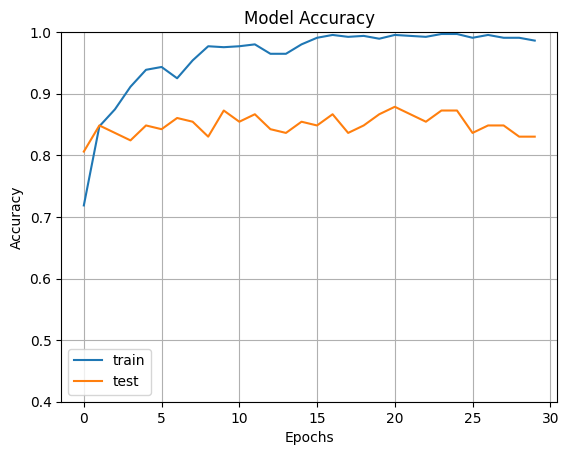

In [ ]:
fig1 = plt.gcf()
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
history_2 = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

Epoch 1/30
21/21 [==============================] - 16s 461ms/step - loss: 1.7638 - accuracy: 0.6575 - val_loss: 0.5992 - val_accuracy: 0.7455
Epoch 2/30
21/21 [==============================] - 9s 428ms/step - loss: 0.5110 - accuracy: 0.7982 - val_loss: 0.4637 - val_accuracy: 0.8061
Epoch 3/30
21/21 [==============================] - 9s 425ms/step - loss: 0.3976 - accuracy: 0.8440 - val_loss: 0.4434 - val_accuracy: 0.8121
Epoch 4/30
21/21 [==============================] - 9s 431ms/step - loss: 0.3055 - accuracy: 0.8960 - val_loss: 0.4314 - val_accuracy: 0.8242
Epoch 5/30
21/21 [==============================] - 9s 442ms/step - loss: 0.2972 - accuracy: 0.8777 - val_loss: 0.3832 - val_accuracy: 0.8667
Epoch 6/30
21/21 [==============================] - 9s 436ms/step - loss: 0.2313 - accuracy: 0.9190 - val_loss: 0.4338 - val_accuracy: 0.8242
Epoch 7/30
21/21 [==============================] - 9s 421ms/step - loss: 0.2042 - accuracy: 0.9174 - val_loss: 0.4222 - val_accuracy: 0.8667
Epoch

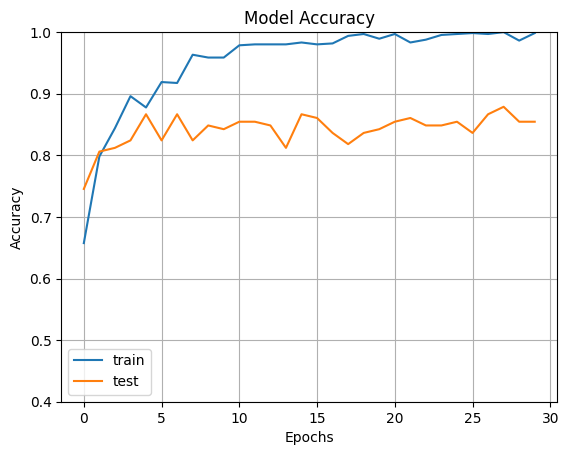

In [ ]:
fig1 = plt.gcf()
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

# Training the Model (with mixup)

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
mixup_history = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

Epoch 1/30
21/21 [==============================] - 13s 473ms/step - loss: 1.2512 - accuracy: 0.7003 - val_loss: 0.6079 - val_accuracy: 0.7879
Epoch 2/30
21/21 [==============================] - 9s 426ms/step - loss: 0.5666 - accuracy: 0.7951 - val_loss: 0.5514 - val_accuracy: 0.7939
Epoch 3/30
21/21 [==============================] - 9s 425ms/step - loss: 0.4459 - accuracy: 0.8700 - val_loss: 0.4045 - val_accuracy: 0.8788
Epoch 4/30
21/21 [==============================] - 9s 422ms/step - loss: 0.4340 - accuracy: 0.8884 - val_loss: 0.4272 - val_accuracy: 0.8424
Epoch 5/30
21/21 [==============================] - 9s 419ms/step - loss: 0.3702 - accuracy: 0.9128 - val_loss: 0.4054 - val_accuracy: 0.8545
Epoch 6/30
21/21 [==============================] - 9s 423ms/step - loss: 0.3678 - accuracy: 0.9098 - val_loss: 0.4120 - val_accuracy: 0.8485
Epoch 7/30
21/21 [==============================] - 9s 436ms/step - loss: 0.3139 - accuracy: 0.9373 - val_loss: 0.4005 - val_accuracy: 0.8424
Epoch

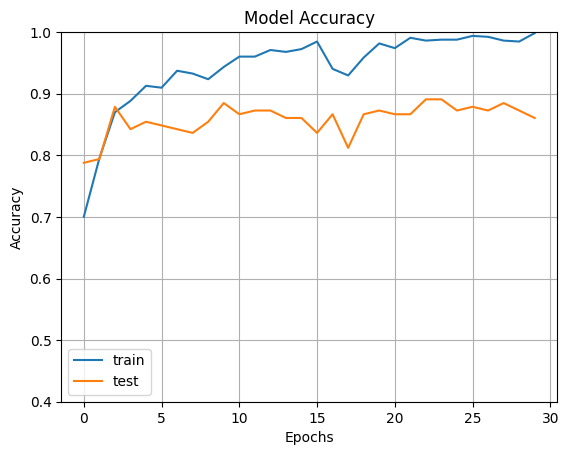

In [ ]:
fig1 = plt.gcf()
plt.plot(mixup_history.history['accuracy'])
plt.plot(mixup_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
mixup_history_1 = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

Epoch 1/30
21/21 [==============================] - 13s 457ms/step - loss: 1.6469 - accuracy: 0.6850 - val_loss: 0.5970 - val_accuracy: 0.7394
Epoch 2/30
21/21 [==============================] - 9s 418ms/step - loss: 0.5757 - accuracy: 0.7813 - val_loss: 0.4890 - val_accuracy: 0.8242
Epoch 3/30
21/21 [==============================] - 9s 422ms/step - loss: 0.4707 - accuracy: 0.8349 - val_loss: 0.4954 - val_accuracy: 0.8000
Epoch 4/30
21/21 [==============================] - 9s 436ms/step - loss: 0.4254 - accuracy: 0.8746 - val_loss: 0.3835 - val_accuracy: 0.8485
Epoch 5/30
21/21 [==============================] - 9s 416ms/step - loss: 0.3483 - accuracy: 0.9052 - val_loss: 0.3621 - val_accuracy: 0.8424
Epoch 6/30
21/21 [==============================] - 9s 418ms/step - loss: 0.3559 - accuracy: 0.9021 - val_loss: 0.3454 - val_accuracy: 0.8727
Epoch 7/30
21/21 [==============================] - 9s 411ms/step - loss: 0.3046 - accuracy: 0.9266 - val_loss: 0.3512 - val_accuracy: 0.8667
Epoch

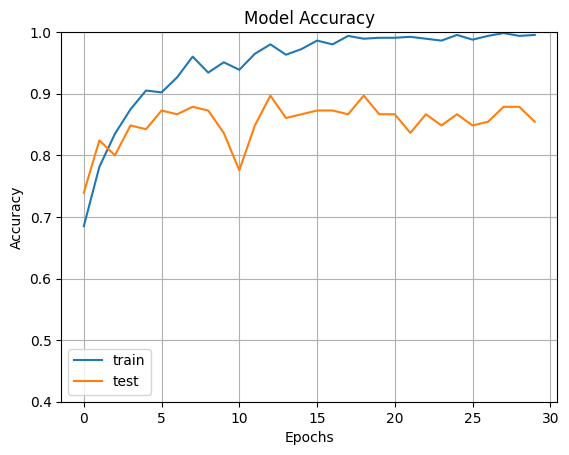

In [ ]:
fig1 = plt.gcf()
plt.plot(mixup_history_1.history['accuracy'])
plt.plot(mixup_history_1.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
mixup_history_2 = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

Epoch 1/30
21/21 [==============================] - 13s 460ms/step - loss: 1.5142 - accuracy: 0.6437 - val_loss: 0.5936 - val_accuracy: 0.7758
Epoch 2/30
21/21 [==============================] - 9s 422ms/step - loss: 0.5784 - accuracy: 0.7875 - val_loss: 0.4945 - val_accuracy: 0.8242
Epoch 3/30
21/21 [==============================] - 9s 418ms/step - loss: 0.4734 - accuracy: 0.8532 - val_loss: 0.4384 - val_accuracy: 0.8485
Epoch 4/30
21/21 [==============================] - 9s 417ms/step - loss: 0.4138 - accuracy: 0.8807 - val_loss: 0.4554 - val_accuracy: 0.8364
Epoch 5/30
21/21 [==============================] - 9s 428ms/step - loss: 0.3690 - accuracy: 0.8930 - val_loss: 0.4016 - val_accuracy: 0.8667
Epoch 6/30
21/21 [==============================] - 9s 441ms/step - loss: 0.3859 - accuracy: 0.9052 - val_loss: 0.3824 - val_accuracy: 0.8606
Epoch 7/30
21/21 [==============================] - 9s 434ms/step - loss: 0.3491 - accuracy: 0.9220 - val_loss: 0.3579 - val_accuracy: 0.8848
Epoch

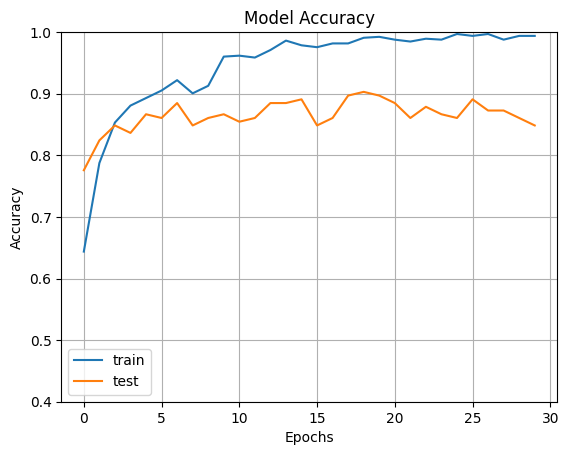

In [ ]:
fig1 = plt.gcf()
plt.plot(mixup_history_2.history['accuracy'])
plt.plot(mixup_history_2.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [ ]:
num_epochs = 30

resnet_model_1.compile(optimizer=Adam(learning_rate=0.001),loss=mixup_criterion,metrics=['accuracy'])
mixup_history_test = resnet_model_1.fit(train_ds,validation_data=val_ds,epochs=num_epochs)

Epoch 1/30
21/21 [==============================] - 14s 502ms/step - loss: 1.4083 - accuracy: 0.6835 - val_loss: 0.5316 - val_accuracy: 0.7879
Epoch 2/30
21/21 [==============================] - 10s 456ms/step - loss: 0.5496 - accuracy: 0.8119 - val_loss: 0.4486 - val_accuracy: 0.8485
Epoch 3/30
21/21 [==============================] - 10s 459ms/step - loss: 0.4509 - accuracy: 0.8532 - val_loss: 0.3791 - val_accuracy: 0.8606
Epoch 4/30
21/21 [==============================] - 10s 456ms/step - loss: 0.4155 - accuracy: 0.8823 - val_loss: 0.3595 - val_accuracy: 0.8788
Epoch 5/30
21/21 [==============================] - 9s 448ms/step - loss: 0.3751 - accuracy: 0.8838 - val_loss: 0.3856 - val_accuracy: 0.8606
Epoch 6/30
21/21 [==============================] - 9s 441ms/step - loss: 0.3413 - accuracy: 0.9205 - val_loss: 0.3739 - val_accuracy: 0.8727
Epoch 7/30
21/21 [==============================] - 10s 449ms/step - loss: 0.3356 - accuracy: 0.9235 - val_loss: 0.3564 - val_accuracy: 0.8848
E

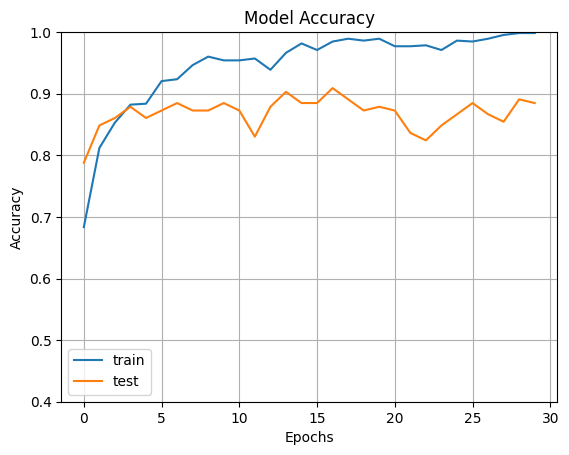

In [ ]:
fig1 = plt.gcf()
plt.plot(mixup_history_test.history['accuracy'])
plt.plot(mixup_history_test.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

# Save Model

In [ ]:
resnet_model_1.save('/content/drive/MyDrive/CMPT983/model.keras')

# Load Model

In [ ]:
@keras.saving.register_keras_serializable(package="my_model")
class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height, img_width, 3),
                   pooling='avg',classes=4,
                   weights='imagenet')
        for layer in self.pretrained_model.layers:
                layer.trainable=False
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(512, activation="relu")
        self.dense2 = keras.layers.Dense(4, activation="softmax")
        self.flag = tf.Variable(0, trainable=False)

    def call(self, inputs, training=None):
        self.flag = 0
        x = self.pretrained_model(inputs)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [ ]:
@keras.saving.register_keras_serializable(package="my_loss", name="mixup_criterion")
def mixup_criterion(y_a, pred, criterion=tf.losses.CategoricalCrossentropy(),):
    """ Updated loss for mixup.
    Args:
    -----
    criterion: loss function to use, example: crossentropy loss
    preds: predictions from network
    y_a: original labels
    y_b: labels of the shuffled batch
    lam: alpha used for mixup
    """
    return criterion(y_a, pred)

In [ ]:
model = MyModel()
model = keras.models.load_model('/content/drive/MyDrive/CMPT983/model.keras')

# Evaluate Model

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print(f"Loss:      {loss:.4f}")
print(f"Accuracy:  {accuracy*100:.4f}%")